# Introduction

This notebook analyzes U.S. justice statistics—incident-level microdata from the Bureau of Justice Statistics’ National Crime Victimization Survey (NCVS)—to describe patterns in the offender and crime context (what happened, where/when, weapons, relationship, reporting, aftermath). 

**Unit of analysis.** Each row represents a single incident, restricted to **single-offender** cases. Records are keyed by a stable `UniqueID` built from `YEARQ`, `IDHH`, and `IDPER` with a deterministic sequence.

**What’s in scope.** The analysis draws from themed slices of the incident file:
- Offender characteristics (single-offender items)
- Incident details (time/place/context)
- Offense type
- Offender–victim relationship
- Incident reporting
- Victim self-protection
- Third-party assistance
- Victim aftermath (injury, care, costs, safety perceptions)

**What’s out of scope.** Survey/replicate **weights** and **victim demographic** variables. Results are therefore **unweighted** and descriptive; many items are **universe-restricted**, so missingness is expected outside eligible incidents.

**Data objects.** We materialize a base table, `analytic_single_offender` (indexed on `UniqueID`), and expose the themes as SQL **views** for easy joining and exploration. Details on preparation and analysis steps follow in the next section.


## Analytical Approach

This analysis uses a structured workflow centered on **thematic subsets** drawn from the NCVS **incident** file and joined by a single key (`UniqueID`). The focus is on **offender** and **incident context**; *victim demographics are excluded*.

### Planned Subsets for Study
1. **Offender Demographics** — `V4236–V4245` (sex, age, race categories for single-offender incidents)  
2. **Incident Details** — `V4012–V4025` (when/where/context)
3. **Offense Type** — `V4077–V4108` (what happened / classification)
4. **Offender–Victim Relationship** — `V4512–V4523` (relationship type)
5. **Incident Reporting** — `V4399–V4422` (reported to police; reasons)
6. **Victim Self-Protection** — `V4143–V4183` (self-protective actions)
7. **Third-Party Assistance** — `V4184–V4202` (help from others)
8. **Victim Aftermath** — `V4110–V4140A` (injury, medical care, costs, safety perceptions)

> Offense-type extras: a tidy table `offense_type_long` (melted with labels) and a per-incident flag `v_offense_type_any`.

### Process
1. **Dataset Documentation** — Note scope/structure using the official codebook.
2. **Data Preparation** — Read selected columns from `Data.sav`; drop weights (codebook row ≥ 621 and any `wgt/weight`).  
   Build `UniqueID = YEARQ_IDHH_IDPER_seq` (1-indexed sequence per `(YEARQ, IDHH, IDPER)`), index it in SQLite.  
   Restrict to **single-offender** incidents: `V4234` ≠ “More than one” and `V4249 < 2` (or missing).
3. **Subset Extraction** — For each theme above, create a SQL **view** from `analytic_single_offender`.  
   Additionally, create `offense_type_long` and `v_offense_type_any`.
4. **Labeling & Recodes** — Use SPSS value labels for readable `_label` fields; collapse rare/unknown codes where helpful; respect universe (branching) when computing denominators.
5. **Analysis** — Descriptive profiles and cross-tabs across themes (e.g., weapon × reporting, relationship × injury).  
   Optional exploratory models (unweighted) with clear caveats.

**Notes:** Results are **unweighted** and reflect only incidents in scope for each item (branching implies expected missingness).


# Dataset Description

## Overview
This dataset originates from the **Bureau of Justice Statistics (BJS)**, the principal U.S. federal statistical agency charged with collecting, analyzing, and disseminating data on **crime, criminal victimization, offenders, and the criminal justice system** across all levels of government. Established in **1979**, BJS aggregates data from thousands of agencies and publishes both microdata and summary tables via the **National Archive of Criminal Justice Data (NACJD)** :contentReference[oaicite:1]{index=1}. Their data are leveraged for policy-making, research, and public transparency.

Microdata files—including full incident-level records and codebooks—are archived in **NACJD** and form the basis for aggregated summaries in BJS reports, dashboards, and tools :contentReference[oaicite:2]{index=2}.

## Unit of Observation
- **Type**: Individual incident or victim-offender record (depending on dataset structure).
- **Geographic Scope**: United States (across states and potentially local jurisdictions).
- **Time Frame**: *2021*.

## Population Covered
Includes both **reported and unreported** incidents as collected through victimization surveys or administrative sources, reflecting multiple offender and victim characteristics.

## Data Collection Method
Records may be derived from:
- **Victimization surveys**, self-reported by individuals.
- **Administrative data**, sourced from law enforcement, courts, and correctional agencies.

These microdata are compiled, standardized, and disseminated through NACJD for public and research use.


---


In [185]:
# --- SQLite helpers (place at top of notebook) ---
from sqlalchemy import create_engine, text
import pandas as pd

DB_PATH = "/Users/deb/anaconda_projects/dissertation-sql/victim_analysis.db"  # edit if you move the DB
engine = create_engine(f"sqlite:///{DB_PATH}", future=True)

def q(sql: str, **params) -> pd.DataFrame:
    """
    Run a SELECT and return a pandas DataFrame.
    Usage: q("SELECT COUNT(1) AS n FROM analytic_single_offender")
    """
    with engine.begin() as conn:
        return pd.read_sql_query(text(sql), conn, params=params)

def q1(sql: str, **params):
    """
    Run a SELECT that returns a single scalar (first column of first row).
    Usage: q1("SELECT COUNT(1) FROM analytic_single_offender")
    """
    with engine.begin() as conn:
        result = conn.execute(text(sql), params)
        row = result.first()
        return None if row is None else row[0]

def exec_sql(sql: str, **params) -> None:
    """
    Run DDL/DML (CREATE VIEW, DROP TABLE, INSERT, etc.). Returns nothing.
    Usage: exec_sql("CREATE VIEW v_test AS SELECT 1 AS x")
    """
    with engine.begin() as conn:
        conn.execute(text(sql), params)

def catalog(limit: int = 50) -> pd.DataFrame:
    """List tables/views in the database."""
    return q(f"""
        SELECT name, type
        FROM sqlite_master
        WHERE type IN ('table','view')
        ORDER BY type, name
        LIMIT {int(limit)}
    """)

def dispose_engine():
    """Close pooled connections (useful before long breaks)."""
    engine.dispose()


In [58]:
# 0) Sanity: does the DB file exist?
from pathlib import Path
Path(DB_PATH).exists()


True

In [59]:
# --- quick viewers (add once per kernel) ---

def head(view, n=5):
    """Peek at first n rows of a table/view."""
    return q(f'SELECT * FROM "{view}" LIMIT {int(n)}')

def columns(view):
    """List column names for a table/view (works for views too)."""
    return list(q(f'SELECT * FROM "{view}" LIMIT 0').columns)

def freq(view, col, limit=20):
    """Frequency table for one column."""
    return q(f'''
        SELECT {col} AS value, COUNT(*) AS n
        FROM "{view}"
        GROUP BY {col}
        ORDER BY n DESC
        LIMIT {int(limit)}
    ''')

def crosstab(view, col1, col2):
    """Simple 2-way count."""
    return q(f'''
        SELECT {col1} AS {col1}, {col2} AS {col2}, COUNT(*) AS n
        FROM "{view}"
        GROUP BY {col1}, {col2}
        ORDER BY n DESC
    ''')


In [60]:
# base views that currently exist (not mirrors)
base_set = set(q("""
  SELECT name FROM sqlite_master
  WHERE type='view' AND name LIKE 'v_%' AND name NOT LIKE '%_sf'
""")["name"].tolist())

# mirrors that currently exist
sf_views = q("""
  SELECT name FROM sqlite_master
  WHERE type='view' AND name LIKE 'v_%_sf'
""")["name"].tolist()

# mirrors whose base view is missing -> drop them
orphaned = [v for v in sf_views if v[:-3] not in base_set]   # strip "_sf"
for v in orphaned:
    exec_sql(f'DROP VIEW IF EXISTS "{v}"')

print("Dropped orphan mirrors:", orphaned)


Dropped orphan mirrors: []


In [61]:
sf_views = q("""
  SELECT name FROM sqlite_master
  WHERE type='view' AND name LIKE 'v_%_sf'
  ORDER BY name
""")["name"].tolist()

counts = [(v, q1(f'SELECT COUNT(*) FROM "{v}"')) for v in sf_views]
counts


[('v_incident_details_sf', 2076),
 ('v_incident_reporting_sf', 2076),
 ('v_offender_demographics_sf', 2076),
 ('v_offender_victim_relationship_sf', 2076),
 ('v_offense_type_any_sf', 1514),
 ('v_offense_type_sf', 2076),
 ('v_third_party_assistance_sf', 2076),
 ('v_victim_demographics_sf', 2076),
 ('v_victim_self_protection_sf', 2076),
 ('v_weapon_sf', 2076)]

In [157]:
q("""
SELECT *
FROM v_offender_demographics_sf
LIMIT 20
""")


,UniqueID,V4084,V4085,V4086,V4087,V4088,V4089,V4090,V4091,V4092,V4093,V4094,V4095
0,2021.1_1710111608023176563845223_1710111608023...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,2021.1_1710271999352528565649112_1710271999352...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,2021.1_1710404158350893565959322_1710404158350...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
3,2021.1_1710620299412156564932122_1710620299412...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
4,2021.1_1710623525467337564938132_1710623525467...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
5,2021.1_1710714133136665563659132_1710714133136...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
6,2021.1_1710763558413474564538212_1710763558413...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2021.1_1710794633139828565682113_1710794633139...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
8,2021.1_1710794633139828565682113_1710794633139...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
9,2021.1_1710850208562067563836112_1710850208562...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
[col for col in all_cols if col.startswith("V4236")]


[]

In [166]:
exec_sql("DROP TABLE IF EXISTS analytic_single_offender")

exec_sql("""
CREATE TABLE analytic_single_offender AS
SELECT *
FROM analytic_single_offender_backup
""")


In [164]:
# List all tables in the database
tables = q("SELECT name FROM sqlite_master WHERE type='table'")["name"].tolist()

found_in = []
for t in tables:
    cols = q(f"PRAGMA table_info('{t}')")["name"].tolist()
    if "V4236" in cols:
        found_in.append(t)

found_in


['Offender_Demographics',
 'stg_single_offender',
 'stg_multi_offender',
 'analytic_single_offender_backup']

In [167]:
q("PRAGMA table_info('analytic_single_offender')")


,cid,name,type,notnull,dflt_value,pk
0,0,_orig_idx,INT,0,None,0
1,1,YEARQ,REAL,0,None,0
2,2,IDHH,TEXT,0,None,0
3,3,IDPER,TEXT,0,None,0
4,4,V4012,REAL,0,None,0
...,...,...,...,...,...,...
159,159,V4522,REAL,0,None,0
160,160,V4523,REAL,0,None,0
161,161,V4234_label,TEXT,0,None,0
162,162,_seq,INT,0,None,0


In [165]:
source_table = "analytic_single_offender_backup"

# Confirm V4236 is there
q(f"PRAGMA table_info('{source_table}')")


,cid,name,type,notnull,dflt_value,pk
0,0,_orig_idx,BIGINT,0,None,0
1,1,YEARQ,FLOAT,0,None,0
2,2,IDHH,TEXT,0,None,0
3,3,IDPER,TEXT,0,None,0
4,4,V4012,FLOAT,0,None,0
...,...,...,...,...,...,...
159,159,V4522,FLOAT,0,None,0
160,160,V4523,FLOAT,0,None,0
161,161,V4234_label,TEXT,0,None,0
162,162,_seq,BIGINT,0,None,0


In [168]:
# Replace analytic_single_offender with its backup
exec_sql("DROP TABLE IF EXISTS analytic_single_offender")

exec_sql("""
CREATE TABLE analytic_single_offender AS
SELECT *
FROM analytic_single_offender_backup
""")

# Confirm V4236 is present now
q("PRAGMA table_info('analytic_single_offender')")["name"].tolist()


['_orig_idx',
 'YEARQ',
 'IDHH',
 'IDPER',
 'V4012',
 'V4013',
 'V4014',
 'V4015',
 'V4016',
 'V4017',
 'V4018',
 'V4019',
 'V4022',
 'V4023',
 'V4025',
 'V4049',
 'V4050',
 'V4051',
 'V4052',
 'V4053',
 'V4054',
 'V4055',
 'V4056',
 'V4077',
 'V4078',
 'V4079',
 'V4080',
 'V4081',
 'V4082',
 'V4083',
 'V4084',
 'V4085',
 'V4086',
 'V4087',
 'V4088',
 'V4089',
 'V4090',
 'V4091',
 'V4092',
 'V4093',
 'V4094',
 'V4095',
 'V4096',
 'V4097',
 'V4099',
 'V4100',
 'V4101',
 'V4102',
 'V4103',
 'V4104',
 'V4105',
 'V4106',
 'V4107',
 'V4108',
 'V4143',
 'V4144',
 'V4145',
 'V4146',
 'V4147',
 'V4148',
 'V4149',
 'V4150',
 'V4151',
 'V4152',
 'V4153',
 'V4154',
 'V4155',
 'V4156',
 'V4157',
 'V4158',
 'V4159',
 'V4160',
 'V4161',
 'V4162',
 'V4163',
 'V4164',
 'V4165',
 'V4166',
 'V4167',
 'V4168',
 'V4169',
 'V4170',
 'V4171',
 'V4172',
 'V4173',
 'V4174',
 'V4175',
 'V4176',
 'V4177',
 'V4178',
 'V4179',
 'V4180',
 'V4181',
 'V4182',
 'V4183',
 'V4184',
 'V4185',
 'V4186',
 'V4187',
 'V4188

In [169]:
# =========================
# ONE-CELL CONSOLIDATED RUN
# =========================

import re
from sqlalchemy import text

# ---- 0) Inspect table columns and helpers ----
cols_df = q("PRAGMA table_info('analytic_single_offender')")
all_cols = [c for c in cols_df["name"].tolist()]
ucols   = [c.upper() for c in all_cols]
name2exact = {c.upper(): c for c in all_cols}  # preserve exact casing for SQL

def num(code: str) -> int | None:
    """Return numeric part of 'V4077', 'V4140A' -> 4077 / 4140 (None if not a V-code)."""
    m = re.match(r"V(\d+)", code.upper())
    return int(m.group(1)) if m else None

def between(lo: int, hi: int) -> list[str]:
    """Return exact-cased column names whose V-number is lo..hi (inclusive)."""
    out = []
    for U in ucols:
        n = num(U)
        if n is not None and lo <= n <= hi:
            out.append(name2exact[U])
    return out

def make_view(view: str, colnames: list[str]):
    colnames = ["UniqueID"] + [c for c in colnames if c in all_cols]
    if len(colnames) <= 1:
        return False  # nothing to create
    select_cols = ", ".join(colnames)
    exec_sql(f"DROP VIEW IF EXISTS {view}")
    exec_sql(f"CREATE VIEW {view} AS SELECT {select_cols} FROM analytic_single_offender")
    return True

# ---- 1) (Re)create base thematic views (only if their columns exist) ----
themes = {
    "v_offender_demographics": between(4236, 4245),
    "v_incident_details":      between(4012, 4025),
    "v_weapon":                between(4049, 4056),
    "v_offense_type":          between(4077, 4108),
    "v_offender_victim_relationship": between(4512, 4523),
    "v_incident_reporting":    between(4399, 4422),
    "v_victim_self_protection":between(4143, 4183),
    "v_third_party_assistance":between(4184, 4202),
    "v_victim_aftermath":      between(4110, 4140),
}

created = {}
for view, cols in themes.items():
    ok = make_view(view, cols)
    if ok: created[view] = len(cols)

# ---- 2) Define the single-offender universe (V4234 == 1) ----
SINGLE_CODE = 1  # "Only one"
exec_sql("DROP VIEW IF EXISTS v_single_offender")
exec_sql(f"""
CREATE VIEW v_single_offender AS
SELECT * FROM analytic_single_offender
WHERE CAST(V4234 AS INTEGER) = {SINGLE_CODE}
""")
n_so = q1("SELECT COUNT(*) FROM v_single_offender")

# ---- 3) Build single-offender mirrors for all base v_* views that exist ----
#      (skip v_single_offender itself; avoid mirroring mirrors)
base_views = q("""
  SELECT name FROM sqlite_master
  WHERE type='view' AND name LIKE 'v_%'
""")["name"].tolist()

to_mirror = [v for v in base_views
             if v not in {"v_single_offender", "v_single_offender_only"}
             and not v.endswith("_sf")]

for v in to_mirror:
    exec_sql(f'DROP VIEW IF EXISTS "{v}_sf"')
    exec_sql(f'''
      CREATE VIEW "{v}_sf" AS
      SELECT v.*
      FROM "{v}" AS v
      JOIN v_single_offender AS s USING (UniqueID)
    ''')

# remove accidental double mirrors if any
dupes = q("SELECT name FROM sqlite_master WHERE type='view' AND name GLOB 'v_*_sf_sf'")["name"].tolist()
for v in dupes:
    exec_sql(f'DROP VIEW IF EXISTS "{v}"')

# ---- 4) (Optional) offense-type tidy + flag on filtered set ----
sf_views = q("""
  SELECT name FROM sqlite_master
  WHERE type='view' AND name LIKE 'v_%_sf'
""")["name"].tolist()

if "v_offense_type_sf" in sf_views:
    df = q('SELECT * FROM "v_offense_type_sf"')
    long = df.melt(id_vars="UniqueID", var_name="var", value_name="code").dropna(subset=["code"])
    long.to_sql("offense_type_long_sf", con=engine, if_exists="replace", index=False)
    exec_sql("CREATE INDEX IF NOT EXISTS idx_otl_sf_uid ON offense_type_long_sf(UniqueID)")
    exec_sql("DROP VIEW IF EXISTS v_offense_type_any_sf")
    exec_sql("""
      CREATE VIEW v_offense_type_any_sf AS
      SELECT UniqueID, CASE WHEN COUNT(*)>0 THEN 1 ELSE 0 END AS any_offense_type
      FROM offense_type_long_sf
      GROUP BY UniqueID
    """)

# ---- 5) Report what we have (counts per mirror) ----
sf_views = q("""
  SELECT name FROM sqlite_master
  WHERE type='view' AND name LIKE 'v_%_sf'
  ORDER BY name
""")["name"].tolist()

counts = [(v, q1(f'SELECT COUNT(*) FROM "{v}"')) for v in sf_views]

print("✅ Single-offender universe:", n_so)
print("✅ Base views created (theme -> #vars):", created)
print("✅ Mirrors (_sf) and row counts:")
for v, n in counts:
    print(f"   - {v}: {n}")


✅ Single-offender universe: 2076
✅ Base views created (theme -> #vars): {'v_offender_demographics': 10, 'v_incident_details': 11, 'v_weapon': 8, 'v_offense_type': 31, 'v_offender_victim_relationship': 11, 'v_incident_reporting': 24, 'v_victim_self_protection': 41, 'v_third_party_assistance': 19}
✅ Mirrors (_sf) and row counts:
   - v_incident_details_sf: 2076
   - v_incident_reporting_sf: 2076
   - v_offender_demographics_sf: 2076
   - v_offender_victim_relationship_sf: 2076
   - v_offense_type_any_sf: 1514
   - v_offense_type_sf: 2076
   - v_third_party_assistance_sf: 2076
   - v_victim_demographics_sf: 2076
   - v_victim_self_protection_sf: 2076
   - v_weapon_sf: 2076


In [155]:
# =========================
# ONE-CELL CONSOLIDATED RUN
# =========================

import re
from sqlalchemy import text

# ---- 0) Inspect table columns and helpers ----
cols_df = q("PRAGMA table_info('analytic_single_offender')")
all_cols = [c for c in cols_df["name"].tolist()]
ucols   = [c.upper() for c in all_cols]
name2exact = {c.upper(): c for c in all_cols}  # preserve exact casing for SQL

def num(code: str) -> int | None:
    """Return numeric part of 'V4077', 'V4140A' -> 4077 / 4140 (None if not a V-code)."""
    m = re.match(r"V(\d+)", code.upper())
    return int(m.group(1)) if m else None

def between(lo: int, hi: int) -> list[str]:
    """Return exact-cased column names whose V-number is lo..hi (inclusive)."""
    out = []
    for U in ucols:
        n = num(U)
        if n is not None and lo <= n <= hi:
            out.append(name2exact[U])
    return out

def make_view(view: str, colnames: list[str]):
    colnames = ["UniqueID"] + [c for c in colnames if c in all_cols]
    if len(colnames) <= 1:
        return False  # nothing to create
    select_cols = ", ".join(colnames)
    exec_sql(f"DROP VIEW IF EXISTS {view}")
    exec_sql(f"CREATE VIEW {view} AS SELECT {select_cols} FROM analytic_single_offender")
    return True

# ---- 1) (Re)create base thematic views (only if their columns exist) ----
themes = {
    "v_offender_demographics": between(4236, 4245),
    "v_incident_details":      between(4012, 4025),
    "v_weapon":                between(4049, 4056),
    "v_offense_type":          between(4077, 4108),
    "v_offender_victim_relationship": between(4512, 4523),
    "v_incident_reporting":    between(4399, 4422),
    "v_victim_self_protection":between(4143, 4183),
    "v_third_party_assistance":between(4184, 4202),
    "v_victim_aftermath":      between(4110, 4140),
}

created = {}
for view, cols in themes.items():
    ok = make_view(view, cols)
    if ok: created[view] = len(cols)

# ---- 2) Define the single-offender universe (V4234 == 1) ----
SINGLE_CODE = 1  # "Only one"
exec_sql("DROP VIEW IF EXISTS v_single_offender")
exec_sql(f"""
CREATE VIEW v_single_offender AS
SELECT * FROM analytic_single_offender
WHERE CAST(V4234 AS INTEGER) = {SINGLE_CODE}
""")
n_so = q1("SELECT COUNT(*) FROM v_single_offender")

# ---- 3) Build single-offender mirrors for all base v_* views that exist ----
#      (skip v_single_offender itself; avoid mirroring mirrors)
base_views = q("""
  SELECT name FROM sqlite_master
  WHERE type='view' AND name LIKE 'v_%'
""")["name"].tolist()

to_mirror = [v for v in base_views
             if v not in {"v_single_offender", "v_single_offender_only"}
             and not v.endswith("_sf")]

for v in to_mirror:
    exec_sql(f'DROP VIEW IF EXISTS "{v}_sf"')
    exec_sql(f'''
      CREATE VIEW "{v}_sf" AS
      SELECT v.*
      FROM "{v}" AS v
      JOIN v_single_offender AS s USING (UniqueID)
    ''')

# remove accidental double mirrors if any
dupes = q("SELECT name FROM sqlite_master WHERE type='view' AND name GLOB 'v_*_sf_sf'")["name"].tolist()
for v in dupes:
    exec_sql(f'DROP VIEW IF EXISTS "{v}"')

# ---- 4) (Optional) offense-type tidy + flag on filtered set ----
sf_views = q("""
  SELECT name FROM sqlite_master
  WHERE type='view' AND name LIKE 'v_%_sf'
""")["name"].tolist()

if "v_offense_type_sf" in sf_views:
    df = q('SELECT * FROM "v_offense_type_sf"')
    long = df.melt(id_vars="UniqueID", var_name="var", value_name="code").dropna(subset=["code"])
    long.to_sql("offense_type_long_sf", con=engine, if_exists="replace", index=False)
    exec_sql("CREATE INDEX IF NOT EXISTS idx_otl_sf_uid ON offense_type_long_sf(UniqueID)")
    exec_sql("DROP VIEW IF EXISTS v_offense_type_any_sf")
    exec_sql("""
      CREATE VIEW v_offense_type_any_sf AS
      SELECT UniqueID, CASE WHEN COUNT(*)>0 THEN 1 ELSE 0 END AS any_offense_type
      FROM offense_type_long_sf
      GROUP BY UniqueID
    """)

# ---- 5) Report what we have (counts per mirror) ----
sf_views = q("""
  SELECT name FROM sqlite_master
  WHERE type='view' AND name LIKE 'v_%_sf'
  ORDER BY name
""")["name"].tolist()

counts = [(v, q1(f'SELECT COUNT(*) FROM "{v}"')) for v in sf_views]

print("✅ Single-offender universe:", n_so)
print("✅ Base views created (theme -> #vars):", created)
print("✅ Mirrors (_sf) and row counts:")
for v, n in counts:
    print(f"   - {v}: {n}")


✅ Single-offender universe: 2076
✅ Base views created (theme -> #vars): {'v_incident_details': 11, 'v_weapon': 2, 'v_offense_type': 12, 'v_incident_reporting': 16}
✅ Mirrors (_sf) and row counts:
   - v_incident_details_sf: 2076
   - v_incident_reporting_sf: 2076
   - v_offender_demographics_sf: 2076
   - v_offender_victim_relationship_sf: 2076
   - v_offense_type_any_sf: 1514
   - v_offense_type_sf: 2076
   - v_third_party_assistance_sf: 2076
   - v_victim_demographics_sf: 2076
   - v_victim_self_protection_sf: 2076
   - v_weapon_sf: 2076


In [170]:
q("PRAGMA table_info('analytic_single_offender')")["name"].tolist()


['_orig_idx',
 'YEARQ',
 'IDHH',
 'IDPER',
 'V4012',
 'V4013',
 'V4014',
 'V4015',
 'V4016',
 'V4017',
 'V4018',
 'V4019',
 'V4022',
 'V4023',
 'V4025',
 'V4049',
 'V4050',
 'V4051',
 'V4052',
 'V4053',
 'V4054',
 'V4055',
 'V4056',
 'V4077',
 'V4078',
 'V4079',
 'V4080',
 'V4081',
 'V4082',
 'V4083',
 'V4084',
 'V4085',
 'V4086',
 'V4087',
 'V4088',
 'V4089',
 'V4090',
 'V4091',
 'V4092',
 'V4093',
 'V4094',
 'V4095',
 'V4096',
 'V4097',
 'V4099',
 'V4100',
 'V4101',
 'V4102',
 'V4103',
 'V4104',
 'V4105',
 'V4106',
 'V4107',
 'V4108',
 'V4143',
 'V4144',
 'V4145',
 'V4146',
 'V4147',
 'V4148',
 'V4149',
 'V4150',
 'V4151',
 'V4152',
 'V4153',
 'V4154',
 'V4155',
 'V4156',
 'V4157',
 'V4158',
 'V4159',
 'V4160',
 'V4161',
 'V4162',
 'V4163',
 'V4164',
 'V4165',
 'V4166',
 'V4167',
 'V4168',
 'V4169',
 'V4170',
 'V4171',
 'V4172',
 'V4173',
 'V4174',
 'V4175',
 'V4176',
 'V4177',
 'V4178',
 'V4179',
 'V4180',
 'V4181',
 'V4182',
 'V4183',
 'V4184',
 'V4185',
 'V4186',
 'V4187',
 'V4188

In [171]:
all_cols = [c for c in cols_df["name"].tolist()]


In [172]:
"V4236" in all_cols


True

In [173]:
# frequency of V4234 (documents the coding; no schema changes)
q("""
SELECT V4234 AS code, COUNT(*) AS n
FROM analytic_single_offender
GROUP BY V4234
ORDER BY n DESC
""")


,code,n
0,NaN,6155
1,1.0,2076
2,3.0,311
3,8.0,87


In [50]:
base_views = q("SELECT name FROM sqlite_master WHERE type='view' AND name LIKE 'v_%'")["name"].tolist()
exclude = {"v_single_offender", "v_single_offender_only"}
to_mirror = [v for v in base_views if v not in exclude and not v.endswith("_sf")]

for v in to_mirror:
    exec_sql(f"DROP VIEW IF EXISTS {v}_sf")
    exec_sql(f"""
        CREATE VIEW {v}_sf AS
        SELECT v.*
        FROM {v} AS v
        JOIN v_single_offender AS s USING (UniqueID)
    """)


In [174]:
cols = q("PRAGMA table_info('analytic_single_offender')")["name"].str.upper().tolist()
"UNIQUEID" in cols, cols[:10]  # True means you're good; False means we need to add it


(True,
 ['_ORIG_IDX',
  'YEARQ',
  'IDHH',
  'IDPER',
  'V4012',
  'V4013',
  'V4014',
  'V4015',
  'V4016',
  'V4017'])

In [175]:
# What views exist right now?
q("SELECT name FROM sqlite_master WHERE type='view' ORDER BY name")

# Only the single-offender mirrors that exist (ends with _sf)
sf_views = q("""
  SELECT name FROM sqlite_master
  WHERE type='view' AND name GLOB 'v_*_sf'
  ORDER BY name
""")["name"].tolist()
sf_views


['v_incident_details_sf',
 'v_incident_reporting_sf',
 'v_offender_demographics_sf',
 'v_offender_victim_relationship_sf',
 'v_offense_type_any_sf',
 'v_offense_type_sf',
 'v_third_party_assistance_sf',
 'v_victim_demographics_sf',
 'v_victim_self_protection_sf',
 'v_weapon_sf']

In [176]:
counts = []
for v in sf_views:
    try:
        n = q1(f"SELECT COUNT(*) FROM {v}")
        counts.append((v, n))
    except Exception as e:
        counts.append((v, f"skip: {type(e).__name__}"))
counts


[('v_incident_details_sf', 2076),
 ('v_incident_reporting_sf', 2076),
 ('v_offender_demographics_sf', 2076),
 ('v_offender_victim_relationship_sf', 2076),
 ('v_offense_type_any_sf', 1514),
 ('v_offense_type_sf', 2076),
 ('v_third_party_assistance_sf', 2076),
 ('v_victim_demographics_sf', 2076),
 ('v_victim_self_protection_sf', 2076),
 ('v_weapon_sf', 2076)]

In [177]:
counts = [(v, q1(f'SELECT COUNT(*) FROM "{v}"')) for v in sf_views]


In [139]:
## --- CONFIG: paths & keys ---
from pathlib import Path
import pandas as pd
import re
import pyreadstat
from sqlalchemy import create_engine

DATA_DIR      = Path("/Users/deb/anaconda_projects/dissertation-sql")
SAV_PATH      = DATA_DIR / "Data.sav"
CODEBOOK_CSV  = DATA_DIR / "Master_Codebook.csv"
SQLITE_PATH   = DATA_DIR / "victim_analysis.db"

YEARQ, IDHH, IDPER = "YEARQ", "IDHH", "IDPER"
CORE_KEEP = ["V4234", "V4249"]   # one vs many; count

# --- THEMES via codebook ROWS (1-indexed, inclusive) ---
# (Victim Demographics left TBD for now)
ROW_THEMES = {
    "offender_demographics":      (274, 285),
    "incident_details":           (14, 27),
    "weapon":                     (53, 60),
    "offense_type":               (81, 112),
    "offender_victim_relationship": (572, 591),
    "incident_reporting":         (456, 479),
    "victim_self_protection":     (182, 222),
    "third_party_assistance":     (223, 241),
    "victim_aftermath":           (114, 179),
    
}

# --- Load codebook and detect variable-name column ---
cb = pd.read_csv(CODEBOOK_CSV, dtype=str)
cb.columns = [c.strip() for c in cb.columns]
var_col_candidates = [c for c in cb.columns if re.search(r"^(var|name)", c, flags=re.I)]
if not var_col_candidates:
    raise ValueError("Could not find a variable-name column (e.g., 'Variable' or 'VarName') in Master_Codebook.csv")
VARCOL = var_col_candidates[0]

# Helper: pull vars by 1-indexed row span, drop NA/weights, uppercase
def vars_by_rows(start_1idx: int, end_1idx: int) -> list:
    s = max(1, int(start_1idx)) - 1
    e = int(end_1idx)
    series = cb.iloc[s:e][VARCOL].dropna().astype(str).str.strip()
    # remove obvious weight-like names
    series = series[~series.str.contains(r"\b(?:wgt|weight)\b", case=False, na=False)]
    return series.str.upper().tolist()

# Build theme -> var list
theme_vars = {}
for theme, (lo, hi) in ROW_THEMES.items():
    theme_vars[theme] = vars_by_rows(lo, hi)

# Union of all vars to read
vars_to_read = set([YEARQ, IDHH, IDPER, *CORE_KEEP])
for lst in theme_vars.values():
    vars_to_read.update(lst)
vars_to_read = sorted(vars_to_read)

# --- Read reduced SAV with only needed columns ---
df, meta = pyreadstat.read_sav(SAV_PATH, usecols=vars_to_read, apply_value_formats=False)

# Label for V4234 if available
lbl4234 = meta.variable_value_labels.get("V4234")
if lbl4234:
    df["V4234_label"] = df["V4234"].map(lbl4234)

# --- Build UniqueID = YEARQ_IDHH_IDPER_seq ---
df = df.reset_index(drop=False).rename(columns={"index": "_orig_idx"})
df = df.sort_values([YEARQ, IDHH, IDPER, "_orig_idx"])
df["_seq"] = df.groupby([YEARQ, IDHH, IDPER]).cumcount() + 1
df["UniqueID"] = (
    df[YEARQ].astype(str).str.strip() + "_" +
    df[IDHH].astype(str).str.strip() + "_" +
    df[IDPER].astype(str).str.strip() + "_" +
    df["_seq"].astype(str)
)

# --- Single-offender filter (robust: V4234 label OR V4249 >= 2) ---
is_multi_4234 = df.get("V4234_label", pd.Series(index=df.index, dtype="object")).str.contains("More than one", case=False, na=False)
is_multi_4249 = pd.to_numeric(df.get("V4249"), errors="coerce").ge(2).fillna(False)
single_mask = ~(is_multi_4234 | is_multi_4249)
analytic = df.loc[single_mask].copy()

# --- Persist base table + per-theme views ---
engine = create_engine(f"sqlite:///{SQLITE_PATH}")
with engine.begin() as conn:
    analytic.to_sql("analytic_single_offender", conn, if_exists="replace", index=False)
    conn.exec_driver_sql("""
        CREATE UNIQUE INDEX IF NOT EXISTS ux_aso_uid ON analytic_single_offender(UniqueID);
    """)
    # Create views per theme (UniqueID + that theme’s vars)
    for theme, cols in theme_vars.items():
        # keep only columns that actually exist (defensive)
        cols_existing = [c for c in cols if c in analytic.columns]
        if not cols_existing:
            continue
        select_cols = ", ".join(["UniqueID"] + cols_existing)
        view_name = "v_" + theme
        conn.exec_driver_sql(f"DROP VIEW IF EXISTS {view_name}")
        conn.exec_driver_sql(f"CREATE VIEW {view_name} AS SELECT {select_cols} FROM analytic_single_offender;")

print(f"✅ Wrote analytic_single_offender and created {len(theme_vars)} theme views (skip empty).")
print({k: len(v) for k, v in theme_vars.items()})


✅ Wrote analytic_single_offender and created 9 theme views (skip empty).
{'offender_demographics': 12, 'incident_details': 14, 'weapon': 8, 'offense_type': 32, 'offender_victim_relationship': 20, 'incident_reporting': 24, 'victim_self_protection': 41, 'third_party_assistance': 19, 'victim_aftermath': 66}


In [178]:
SINGLE_CODE = 1  # change if your table shows a different code for "Only one"

exec_sql("DROP VIEW IF EXISTS v_single_offender")
exec_sql(f"""
CREATE VIEW v_single_offender AS
SELECT *
FROM analytic_single_offender
WHERE CAST(V4234 AS INTEGER) = {SINGLE_CODE}
""")

# check result
q1("SELECT COUNT(*) FROM v_single_offender")


2076

In [179]:
# must be true first
q1("SELECT COUNT(*) FROM v_single_offender")   # should be 2076
q("SELECT name FROM sqlite_master WHERE type='view' AND name LIKE 'v_%'")  # your original views exist


,name
0,v_offense_type_any
1,v_victim_demographics
2,v_single_offender_only
3,v_offender_demographics
4,v_incident_details
5,v_weapon
6,v_offense_type
7,v_offender_victim_relationship
8,v_incident_reporting
9,v_victim_self_protection


In [180]:
# ========= VARIABLE CATALOG (run anytime) =========
import pandas as pd

def cols_of(obj_name: str) -> list[str]:
    """Return column names for a table/view."""
    return list(q(f'SELECT * FROM "{obj_name}" LIMIT 0').columns)

# 1) What are the single-offender mirrors?
sf_views = q("""
  SELECT name FROM sqlite_master
  WHERE type='view' AND name LIKE 'v_%_sf'
  ORDER BY name
""")["name"].tolist()

# 2) Build a catalog: (view, variable)
rows = []
for v in sf_views:
    for c in cols_of(v):
        if c == "UniqueID":       # keep UID separate
            continue
        rows.append({"view": v, "variable": c})

catalog = pd.DataFrame(rows).sort_values(["view","variable"]).reset_index(drop=True)

# 3) Quick summaries
summary = (catalog.groupby("view")["variable"]
           .agg(n_vars="count",
                sample=lambda s: ", ".join(list(s)[:5]) + ("..." if len(s) > 5 else "" ))
           .reset_index())

union_vars = sorted(catalog["variable"].unique())

# 4) Display
print("Views included:", len(sf_views))
display(summary)

print(f"\nUnion of variables across all _sf views (excluding UniqueID): {len(union_vars)}")
for v in union_vars:
    print(v)

# 5) (Optional) write to CSV for your methods appendix
catalog.to_csv("variables_catalog_sf.csv", index=False)
print('\nSaved per-view catalog to variables_catalog_sf.csv')


Views included: 10


,view,n_vars,sample
0,v_incident_details_sf,11,"V4012, V4013, V4014, V4015, V4016..."
1,v_incident_reporting_sf,24,"V4399, V4400, V4401, V4402, V4403..."
2,v_offender_demographics_sf,10,"V4236, V4237, V4238, V4239, V4240..."
3,v_offender_victim_relationship_sf,11,"V4512, V4513, V4514, V4515, V4516..."
4,v_offense_type_any_sf,1,any_offense_type
5,v_offense_type_sf,31,"V4077, V4078, V4079, V4080, V4081..."
6,v_third_party_assistance_sf,19,"V4184, V4185, V4186, V4187, V4188..."
7,v_victim_demographics_sf,1,V4234_label
8,v_victim_self_protection_sf,41,"V4143, V4144, V4145, V4146, V4147..."
9,v_weapon_sf,8,"V4049, V4050, V4051, V4052, V4053..."



Union of variables across all _sf views (excluding UniqueID): 157
V4012
V4013
V4014
V4015
V4016
V4017
V4018
V4019
V4022
V4023
V4025
V4049
V4050
V4051
V4052
V4053
V4054
V4055
V4056
V4077
V4078
V4079
V4080
V4081
V4082
V4083
V4084
V4085
V4086
V4087
V4088
V4089
V4090
V4091
V4092
V4093
V4094
V4095
V4096
V4097
V4099
V4100
V4101
V4102
V4103
V4104
V4105
V4106
V4107
V4108
V4143
V4144
V4145
V4146
V4147
V4148
V4149
V4150
V4151
V4152
V4153
V4154
V4155
V4156
V4157
V4158
V4159
V4160
V4161
V4162
V4163
V4164
V4165
V4166
V4167
V4168
V4169
V4170
V4171
V4172
V4173
V4174
V4175
V4176
V4177
V4178
V4179
V4180
V4181
V4182
V4183
V4184
V4185
V4186
V4187
V4188
V4189
V4190
V4191
V4192
V4193
V4194
V4195
V4196
V4197
V4198
V4199
V4200
V4201
V4202
V4234_label
V4236
V4237
V4238
V4239
V4240
V4241
V4242
V4243
V4244
V4245
V4399
V4400
V4401
V4402
V4403
V4404
V4405
V4406
V4407
V4408
V4409
V4410
V4411
V4412
V4413
V4414
V4415
V4416
V4417
V4418
V4419
V4420
V4421
V4422
V4512
V4513
V4514
V4515
V4516
V4517
V4518
V4519
V4520
V45

In [70]:
base_cols = cols_of("analytic_single_offender")
print(f"analytic_single_offender has {len(base_cols)} columns:")
for c in base_cols:
    print(c)


analytic_single_offender has 109 columns:
_orig_idx
V4001
YEARQ
IDHH
IDPER
V4002
V4003
V4004
V4005
V4006
V4008
V4009
V4010
V4011
V4012
V4013
V4014
V4015
V4016
V4017
V4018
V4019
V4022
V4023
V4025
V4026
V4027
V4028
V4029
V4030
V4031
V4032
V4033
V4034
V4035
V4036
V4037
V4038
V4039
V4040
V4042
V4043
V4044
V4045
V4046
V4047
V4048
V4049
V4050
V4085
V4086
V4087
V4088
V4089
V4090
V4091
V4092
V4093
V4094
V4095
V4234
V4249
V4273
V4274
V4275
V4276
V4277
V4278
V4279
V4280
V4281
V4283
V4284
V4286
V4287
V4288
V4289
V4290
V4291
V4292
V4293
V4294
V4295
V4296
V4297
V4298
V4395
V4396
V4397
V4398
V4399
V4400
V4401
V4402
V4403
V4404
V4405
V4406
V4407
V4408
V4409
V4410
V4411
V4412
V4413
V4414
V4234_label
_seq
UniqueID


In [181]:
# Should return ['V4399'] if present
q("""
SELECT name
FROM pragma_table_info('analytic_single_offender')
WHERE UPPER(name)='V4399'
""")


,name
0,V4399


In [182]:
# counts by code (single-offender filter via UniqueID)
q("""
SELECT V4399 AS code, COUNT(*) AS n
FROM analytic_single_offender
WHERE UniqueID IN (SELECT UniqueID FROM v_single_offender)
GROUP BY V4399
ORDER BY n DESC
""")

# labeled version + percent of the 2,076 single-offender incidents
q("""
SELECT
  CASE CAST(V4399 AS INTEGER)
    WHEN 1 THEN 'Yes'
    WHEN 2 THEN 'No'
    WHEN 3 THEN 'Don''t know'
    ELSE 'Residue/Other'
  END AS reported_to_police,
  COUNT(*) AS n,
  ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM v_single_offender), 1) AS pct_single_offender
FROM analytic_single_offender
WHERE UniqueID IN (SELECT UniqueID FROM v_single_offender)
GROUP BY 1
ORDER BY n DESC
""")


,reported_to_police,n,pct_single_offender
0,No,1164,56.1
1,Yes,890,42.9
2,Don't know,21,1.0
3,Residue/Other,1,0.0


In [183]:
# Rebuild the base view to include V4399 (+ any V44xx neighbors that exist)
all_cols = q("PRAGMA table_info('analytic_single_offender')")["name"].tolist()
report_cols = [c for c in all_cols if c.upper()=='V4399' or (c.upper().startswith('V44') and c[1:].isdigit())]
select_cols = ", ".join(["UniqueID"] + report_cols)

exec_sql("DROP VIEW IF EXISTS v_incident_reporting")
exec_sql(f"CREATE VIEW v_incident_reporting AS SELECT {select_cols} FROM analytic_single_offender")

exec_sql("DROP VIEW IF EXISTS v_incident_reporting_sf")
exec_sql("""
  CREATE VIEW v_incident_reporting_sf AS
  SELECT v.* FROM v_incident_reporting v
  JOIN v_single_offender s USING (UniqueID)
""")

# sanity checks
q1("SELECT COUNT(*) FROM v_incident_reporting_sf")         # should be 2076
q("SELECT * FROM v_incident_reporting_sf LIMIT 0").columns.tolist()  # should include 'V4399'


['UniqueID',
 'V4399',
 'V4400',
 'V4401',
 'V4402',
 'V4403',
 'V4404',
 'V4405',
 'V4406',
 'V4407',
 'V4408',
 'V4409',
 'V4410',
 'V4411',
 'V4412',
 'V4413',
 'V4414',
 'V4415',
 'V4416',
 'V4417',
 'V4418',
 'V4419',
 'V4420',
 'V4421',
 'V4422']

In [74]:
freq("v_incident_reporting_sf", "V4399", 10)


,value,n
0,2.0,1164
1,1.0,890
2,3.0,21
3,8.0,1


In [184]:
# what objects do I have?
q("SELECT type, name FROM sqlite_master ORDER BY type, name")

# peek a few key views
head("v_single_offender", 5)
head("v_incident_reporting_sf", 5)
head("v_weapon_sf", 5)
head("v_offense_type_sf", 5)

# see the schema/columns quickly
columns("v_incident_reporting_sf")

# frequencies
freq("v_incident_reporting_sf", "V4399", 10)   # reported to police
freq("v_weapon_sf", "V4049", 10)               # first weapon field (example)

# crosstab examples
crosstab("v_weapon_sf", "V4049", "V4050")                   # weapon x weapon follow-up
crosstab("v_incident_reporting_sf", "V4399", "V4400")       # police reporting x reason (example)

# offense type (long/tidy) if you built it
head("offense_type_long_sf", 10)
freq("offense_type_long_sf", "code", 20)

# quick counts for all _sf mirrors
sf_views = q("""
  SELECT name FROM sqlite_master
  WHERE type='view' AND name LIKE 'v_%_sf'
  ORDER BY name
""")["name"].tolist()
[(v, q1(f'SELECT COUNT(*) FROM "{v}"')) for v in sf_views]


[('v_incident_details_sf', 2076),
 ('v_incident_reporting_sf', 2076),
 ('v_offender_demographics_sf', 2076),
 ('v_offender_victim_relationship_sf', 2076),
 ('v_offense_type_any_sf', 1514),
 ('v_offense_type_sf', 2076),
 ('v_third_party_assistance_sf', 2076),
 ('v_victim_demographics_sf', 2076),
 ('v_victim_self_protection_sf', 2076),
 ('v_weapon_sf', 2076)]

# Building a Victim-Centric Analysis Dataset from NCVS Data

The NCVS `.sav` file is a **multi-record-type dataset** containing both *person-level* and *incident-level* records.  
To analyze victim demographics and their relationship to incidents, we need to **separate**, **merge**, and **filter** these records.

---

## Why This Process Is Necessary

### 1. Record Separation
- NCVS stores different record types (Household, Person, Incident) in the same file.  
- Victim demographic fields (age, sex, education, marital status, ethnicity) are stored in *person records*, not incident records.  
- Without separating them, demographic data cannot be matched to incidents.

### 2. Linking Victims to Incidents
- Incidents are keyed by a combination of survey year/quarter (`YEARQ`), household ID (`IDHH`), and person ID (`IDPER`).  
- We join victim demographic data from the *person file* to the corresponding *incident record* using these keys.

### 3. Creating a Deterministic UniqueID
- Some households/persons have multiple incidents.  
- We create a **UniqueID** (`YEARQ_IDHH_IDPER_seq`) to distinguish each incident while keeping person context.

### 4. Filtering for Analysis Scope
- **Single-offender** incidents (e.g., `V4248==1`) reduce complexity and improve clarity in relationship analysis.  
- **Victim age > 12** excludes child-only cases where offender/victim dynamics differ significantly.

### 5. Subsetting for Thematic Analysis
The dataset is split into logical subsets:
- `Incident_Details` (location, state, IDs)  
- `Victim_Demographics` (age, sex, education, marital status, ethnicity)  
- `Offender_Demographics` (sex, age, race, behavior)  
- `Offense_Type`, `Offender_Victim_Rel`, `Incident_Reporting`,  
  `Victim_Self_Protect`, `Third_Party_Assist`, and `Victim_Aftermath`.

This modular structure enables efficient querying in SQL.

### 6. SQLite Export
- Each subset is written to SQLite with an index on `UniqueID`.  
- This allows **fast joins** and **flexible SQL analysis** across different victim/offender/incident dimensions.

---

**✅ Outcome:**  
We get a clean, relational dataset where each incident is linked to victim demographics and thematic categories, enabling robust SQL-based exploration of victimization patterns.


## Methods Note: Importance of Incident-Level Restructuring for Victimization and Human Trafficking Analysis

The NCVS dataset, in its raw form, is not optimized for incident-level analysis.  
Records are stored in multiple formats (Household, Person, Incident), and incident details are often distributed across these files.  
Restructuring the dataset so that **each row represents a single incident** is a critical step for both general victimization research and more targeted studies such as human trafficking.

### Why Incident-Level Structure Matters
1. **Unit of Analysis Clarity**  
   - Ensures that the incident — not the household or person — is the primary analytical unit.  
   - Prevents ambiguity when individuals experience multiple incidents.

2. **Direct Linkage of Key Variables**  
   - Allows victim demographics, offender characteristics, incident context, and aftermath variables to be joined in a single view.  
   - Reduces the risk of mismatched data from multiple victim records in the same household.

3. **Pattern and Sequence Detection**  
   - Facilitates tracking of repeated victimizations for the same individual across time.  
   - Enables analysis of temporal patterns, clustering of similar incidents, and victim-offender relationship changes.

4. **Applicability to Human Trafficking Analysis**  
   - Incident-level data allows for targeted filtering based on trafficking indicators (e.g., offender relationship, location type, control behaviors).  
   - Supports integration with external case data from law enforcement or NGOs for multi-source validation.  
   - Enhances the ability to model incident chains, potential grooming patterns, and escalation pathways.

### Outcome
This restructuring provides a **clear, flexible, and analysis-ready framework** that is essential for:
- Identifying statistical trends in general victimization
- Conducting in-depth human trafficking pattern recognition
- Building reproducible workflows for academic and policy research

**Note:** This method forms part of a longer-term dissertation plan to adapt NCVS data for detecting and understanding human trafficking incidents and victimization trajectories.


In [187]:
# Example — adjust to your file
import pandas as pd
df, meta = pyreadstat.read_sav("Data.sav")


In [188]:
# Create IncidentID using NCVS recommended fields
df['IncidentID'] = (
    df['YEARQ'].astype(str) + "_" +
    df['IDHH'].astype(str) + "_" +
    df['IDPER'].astype(str)
)


In [189]:
[col for col in df.columns if "4236" in col]

['V4236']

In [87]:
[col for col in df.columns if "4097" in col]


['V4097']

In [88]:
df['V4097'].value_counts(dropna=False)


V4097
NaN    8315
0.0     660
1.0       7
Name: count, dtype: int64

In [89]:
# Scan all attack_map variables for unique values
for col in attack_map.keys():
    if col in df.columns:
        print(f"\n{col} - {attack_map[col]}")
        print(df[col].value_counts(dropna=False))
    else:
        print(f"\n{col} not found in DataFrame")



V4094 - Raped
V4094
NaN    8315
0.0     622
1.0      45
Name: count, dtype: int64

V4095 - Tried to Rape
V4095
NaN    8315
0.0     653
1.0      14
Name: count, dtype: int64

V4096 - Sexual Assault
V4096
NaN    8315
0.0     627
1.0      40
Name: count, dtype: int64

V4097 - Shot
V4097
NaN    8315
0.0     660
1.0       7
Name: count, dtype: int64

V4098 - Shot at, Missed
V4098
NaN    8315
0.0     667
Name: count, dtype: int64

V4099 - Hit with Gun Held in Hand
V4099
NaN    8315
0.0     663
1.0       4
Name: count, dtype: int64

V4100 - Stabbed / Cut with Knife
V4100
NaN    8315
0.0     657
1.0      10
Name: count, dtype: int64

V4101 - Attack w/ Knife
V4101
NaN    8315
0.0     660
1.0       7
Name: count, dtype: int64

V4102 - Hit by Object Held in Hand
V4102
NaN    8315
0.0     620
1.0      47
Name: count, dtype: int64

V4103 - Hit by Thrown Object
V4103
NaN    8315
0.0     631
1.0      36
Name: count, dtype: int64

V4104 - Attack w/ Other Weapon
V4104
NaN    8315
0.0     647
1.0      

In [93]:
YES_CODE = 1.0

def derive_crime_attempted(row):
    for col, label in attack_map.items():  # committed first
        if row.get(col) == YES_CODE:
            return label
    for col, label in attempt_map.items():  # attempt/threat second
        if row.get(col) == YES_CODE:
            return label
    return None

def derive_crime_committed(row):
    for col, label in attack_map.items():  # only committed
        if row.get(col) == YES_CODE:
            return label
    return None


In [191]:
# Define the mappings from variable name to crime label for ATTEMPTED crimes
attempt_vars = {
    'V4078': 'Threat of Rape',
    'V4079': 'Threat to Kill',
    'V4080': 'Other Threat',
    'V4081': 'Threat Sexual Assault',
    'V4082': 'Sex Contact w/ Force',
    'V4083': 'Sex Contact No Force',
    'V4084': 'Weapon Present',
    'V4085': 'Shot At, Missed',
    'V4086': 'Attempt Attack w/ Knife',
    'V4087': 'Attempt Attack Other Weapon',
    'V4088': 'Object Thrown',
    'V4089': 'Followed or Surrounded',
    'V4090': 'Attempt Hit, Grab, Jump'
}

# Define the mappings from variable name to crime label for COMMITTED crimes
committed_vars = {
    'V4094': 'Raped',
    'V4095': 'Tried to Rape',
    'V4096': 'Sexual Assault',
    'V4097': 'Shot',
    'V4098': 'Shot At, Missed',
    'V4099': 'Hit with Gun Held in Hand',
    'V4100': 'Stabbed / Cut with Knife',
    'V4101': 'Attack w/ Knife',
    'V4102': 'Hit by Object Held in Hand',
    'V4103': 'Hit by Thrown Object',
    'V4104': 'Attack w/ Other Weapon',
    'V4105': 'Hit, Slapped, Knocked Down',
    'V4106': 'Grabbed, Held, Tripped',
    'V4107': 'Other Type of Attack'
}

# Count occurrences for each crime type
attempt_counts = {crime: df[var].sum() for var, crime in attempt_vars.items()}
committed_counts = {crime: df[var].sum() for var, crime in committed_vars.items()}

# Create DataFrames
attempt_df = pd.DataFrame.from_dict(attempt_counts, orient='index', columns=['Attempted Count'])
committed_df = pd.DataFrame.from_dict(committed_counts, orient='index', columns=['Committed Count'])

# Merge into one DataFrame
comparison_df = attempt_df.merge(committed_df, left_index=True, right_index=True, how='outer').fillna(0)

# Calculate percentage committed (of attempted+committed)
comparison_df['Percent Committed'] = (comparison_df['Committed Count'] / 
                                      (comparison_df['Attempted Count'] + comparison_df['Committed Count']) * 100)

# Filter by min_count for either committed or attempted
min_count = 5
comparison_df = comparison_df[(comparison_df['Committed Count'] >= min_count) | 
                               (comparison_df['Attempted Count'] >= min_count)]

# Sort for readability
comparison_df = comparison_df.sort_values(by='Committed Count', ascending=False)

comparison_df


,Attempted Count,Committed Count,Percent Committed
"Hit, Slapped, Knocked Down",0.0,335.0,100.0
"Grabbed, Held, Tripped",0.0,311.0,100.0
Hit by Object Held in Hand,0.0,47.0,100.0
Raped,0.0,45.0,100.0
Sexual Assault,0.0,40.0,100.0
Hit by Thrown Object,0.0,36.0,100.0
Other Type of Attack,0.0,21.0,100.0
Attack w/ Other Weapon,0.0,20.0,100.0
Tried to Rape,0.0,14.0,100.0
Stabbed / Cut with Knife,0.0,10.0,100.0


In [192]:
# Mapping for attempt/threat variables
attempt_map = {
    'V4078': 'Threat of Rape',
    'V4079': 'Threat to Kill',
    'V4080': 'Other Threat',
    'V4081': 'Threat Sexual Assault',
    'V4082': 'Sex Contact w/ Force',
    'V4083': 'Sex Contact No Force',
    'V4084': 'Weapon Present',
    'V4085': 'Shot at, Missed',
    'V4086': 'Attack w/ Knife (Attempt)',
    'V4087': 'Attack w/ Other Weapon (Attempt)',
    'V4088': 'Object Thrown',
    'V4089': 'Followed or Surrounded',
    'V4090': 'Hit, Grab, Jump',
    'V4091': 'Other Attempt/Threat'
}

# Mapping for attack variables
attack_map = {
    'V4094': 'Raped',
    'V4095': 'Tried to Rape',
    'V4096': 'Sexual Assault',
    'V4097': 'Shot',
    'V4098': 'Shot at, Missed',
    'V4099': 'Hit with Gun Held in Hand',
    'V4100': 'Stabbed / Cut with Knife',
    'V4101': 'Attack w/ Knife',
    'V4102': 'Hit by Object Held in Hand',
    'V4103': 'Hit by Thrown Object',
    'V4104': 'Attack w/ Other Weapon',
    'V4105': 'Hit, Slapped, Knocked Down',
    'V4106': 'Grabbed, Held, Tripped',
    'V4107': 'Other Type of Attack'
}

# Function to derive crime_type
def derive_crime_type(row):
    # Check attack variables first
    for col, label in attack_map.items():
        if row.get(col) == 1:
            return label
    # If none found, check attempt/threat variables
    for col, label in attempt_map.items():
        if row.get(col) == 1:
            return label
    return None

# Apply function to create new column
df['crime_type'] = df.apply(derive_crime_type, axis=1)

# Now run frequency counts (excluding unknowns)
crime_counts = df['crime_type'].value_counts().reset_index()
crime_counts.columns = ['Crime Type', 'Count']
crime_counts['Percent'] = (crime_counts['Count'] / crime_counts['Count'].sum()) * 100

print(crime_counts)


                    Crime Type  Count    Percent
0                 Other Threat    652  36.363636
1   Hit, Slapped, Knocked Down    297  16.564417
2               Weapon Present    169   9.425544
3               Threat to Kill    161   8.979364
4       Grabbed, Held, Tripped    159   8.867819
5              Hit, Grab, Jump     52   2.900167
6                        Raped     45   2.509760
7   Hit by Object Held in Hand     44   2.453988
8                Object Thrown     34   1.896263
9               Sexual Assault     34   1.896263
10        Hit by Thrown Object     27   1.505856
11              Threat of Rape     21   1.171221
12               Tried to Rape     14   0.780814
13        Sex Contact No Force     13   0.725042
14      Followed or Surrounded     11   0.613497
15      Attack w/ Other Weapon     10   0.557724
16    Stabbed / Cut with Knife     10   0.557724
17        Other Type of Attack      9   0.501952
18                        Shot      7   0.390407
19       Threat Sexu

Attempted Crimes:
                           Crime  Count
0                  Other Threat    674
1                Weapon Present    273
2                Threat to Kill    165
3       Attempt Hit, Grab, Jump     92
4        Followed or Surrounded     76
5                 Object Thrown     55
6   Attempt Attack Other Weapon     26
7                Threat of Rape     21
8       Attempt Attack w/ Knife     18
9          Sex Contact No Force     15
10              Shot At, Missed     12
11        Threat Sexual Assault      6
12         Sex Contact w/ Force      3

Committed Crimes:
                          Crime  Count
0   Hit, Slapped, Knocked Down    335
1       Grabbed, Held, Tripped    311
2   Hit by Object Held in Hand     47
3                        Raped     45
4               Sexual Assault     40
5         Hit by Thrown Object     36
6         Other Type of Attack     21
7       Attack w/ Other Weapon     20
8                Tried to Rape     14
9     Stabbed / Cut with Knife     

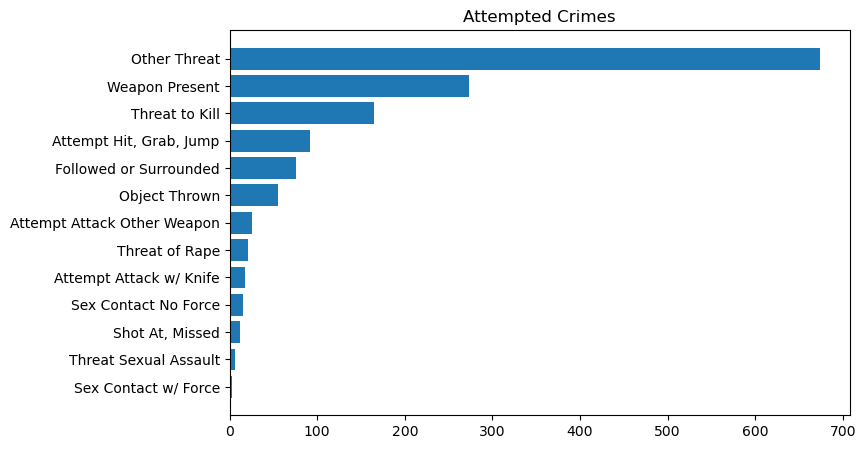

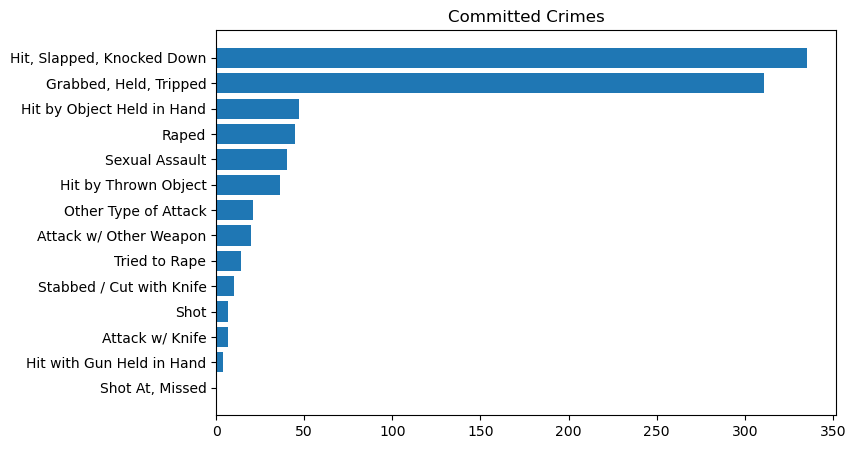

In [193]:
# Filter only Attempt/Threat variables
attempt_vars = [
    "V4078", "V4079", "V4080", "V4081", "V4082", "V4083",
    "V4084", "V4085", "V4086", "V4087", "V4088", "V4089", "V4090"
]

# Filter only Committed variables
committed_vars = [
    "V4094", "V4095", "V4096", "V4097", "V4098", "V4099",
    "V4100", "V4101", "V4102", "V4103", "V4104", "V4105",
    "V4106", "V4107"
]

# Map variable codes to readable labels
attempt_labels = {
    "V4078": "Threat of Rape",
    "V4079": "Threat to Kill",
    "V4080": "Other Threat",
    "V4081": "Threat Sexual Assault",
    "V4082": "Sex Contact w/ Force",
    "V4083": "Sex Contact No Force",
    "V4084": "Weapon Present",
    "V4085": "Shot At, Missed",
    "V4086": "Attempt Attack w/ Knife",
    "V4087": "Attempt Attack Other Weapon",
    "V4088": "Object Thrown",
    "V4089": "Followed or Surrounded",
    "V4090": "Attempt Hit, Grab, Jump"
}

committed_labels = {
    "V4094": "Raped",
    "V4095": "Tried to Rape",
    "V4096": "Sexual Assault",
    "V4097": "Shot",
    "V4098": "Shot At, Missed",
    "V4099": "Hit with Gun Held in Hand",
    "V4100": "Stabbed / Cut with Knife",
    "V4101": "Attack w/ Knife",
    "V4102": "Hit by Object Held in Hand",
    "V4103": "Hit by Thrown Object",
    "V4104": "Attack w/ Other Weapon",
    "V4105": "Hit, Slapped, Knocked Down",
    "V4106": "Grabbed, Held, Tripped",
    "V4107": "Other Type of Attack"
}

# Count Attempted crimes
attempt_counts = (
    df[attempt_vars]
    .apply(lambda x: (x == 1).sum())
    .rename(index=attempt_labels)
    .sort_values(ascending=False)
    .reset_index()
)
attempt_counts.columns = ["Crime", "Count"]

# Count Committed crimes
committed_counts = (
    df[committed_vars]
    .apply(lambda x: (x == 1).sum())
    .rename(index=committed_labels)
    .sort_values(ascending=False)
    .reset_index()
)
committed_counts.columns = ["Crime", "Count"]

# Display separately
print("Attempted Crimes:\n", attempt_counts)
print("\nCommitted Crimes:\n", committed_counts)

# Example: plot each separately
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(attempt_counts["Crime"], attempt_counts["Count"])
plt.title("Attempted Crimes")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(8, 5))
plt.barh(committed_counts["Crime"], committed_counts["Count"])
plt.title("Committed Crimes")
plt.gca().invert_yaxis()
plt.show()


In [194]:
# Example: offender age column
offender_age_col = "V4237"  # replace with your actual column name

# Cross-tab attempted crimes vs offender age
attempt_age_counts = {}
for var, label in attempt_labels.items():
    attempt_age_counts[label] = df[df[var] == 1][offender_age_col].value_counts()

attempt_age_df = pd.DataFrame(attempt_age_counts).fillna(0).astype(int)


In [195]:
committed_age_counts = {}
for var, label in committed_labels.items():
    committed_age_counts[label] = df[df[var] == 1][offender_age_col].value_counts()

committed_age_df = pd.DataFrame(committed_age_counts).fillna(0).astype(int)


Attempted Crimes by Offender Age:
        Threat of Rape  Threat to Kill  Other Threat  Threat Sexual Assault  \
V4237                                                                        
1.0                 0               1             1                      0   
2.0                 0               1            13                      0   
3.0                 0               4             9                      0   
4.0                 1               6            16                      0   
5.0                 5              34            91                      2   

       Sex Contact w/ Force  Sex Contact No Force  Weapon Present  \
V4237                                                               
1.0                       0                     0               2   
2.0                       0                     0               3   
3.0                       0                     1               4   
4.0                       0                     1              11   
5.0 

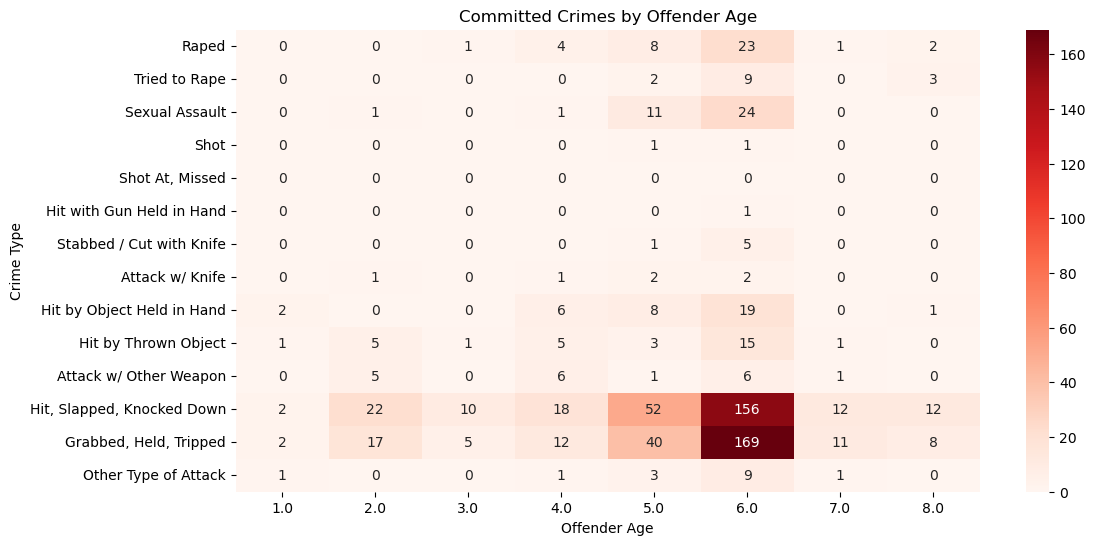

In [119]:
# Display first few rows
print("Attempted Crimes by Offender Age:\n", attempt_age_df.head())
print("\nCommitted Crimes by Offender Age:\n", committed_age_df.head())

# Example: Plot committed crimes heatmap
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(committed_age_df.T, cmap="Reds", annot=True, fmt="d")
plt.title("Committed Crimes by Offender Age")
plt.xlabel("Offender Age")
plt.ylabel("Crime Type")
plt.show()


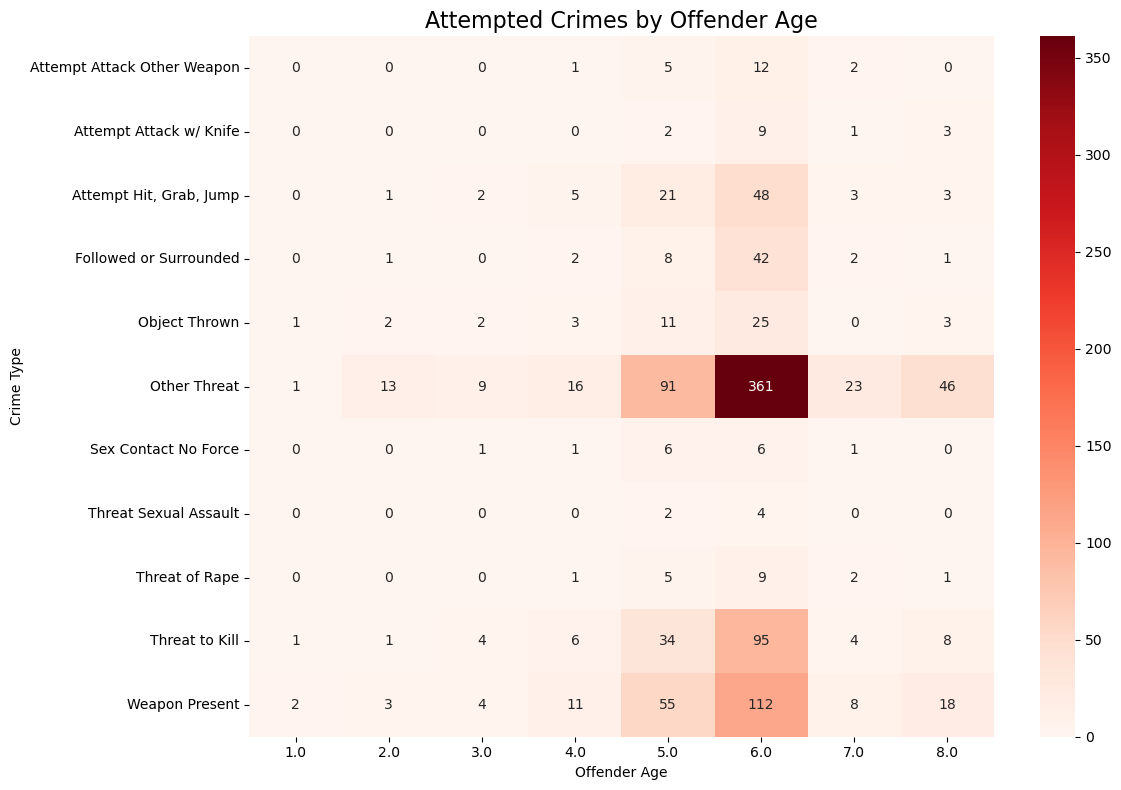

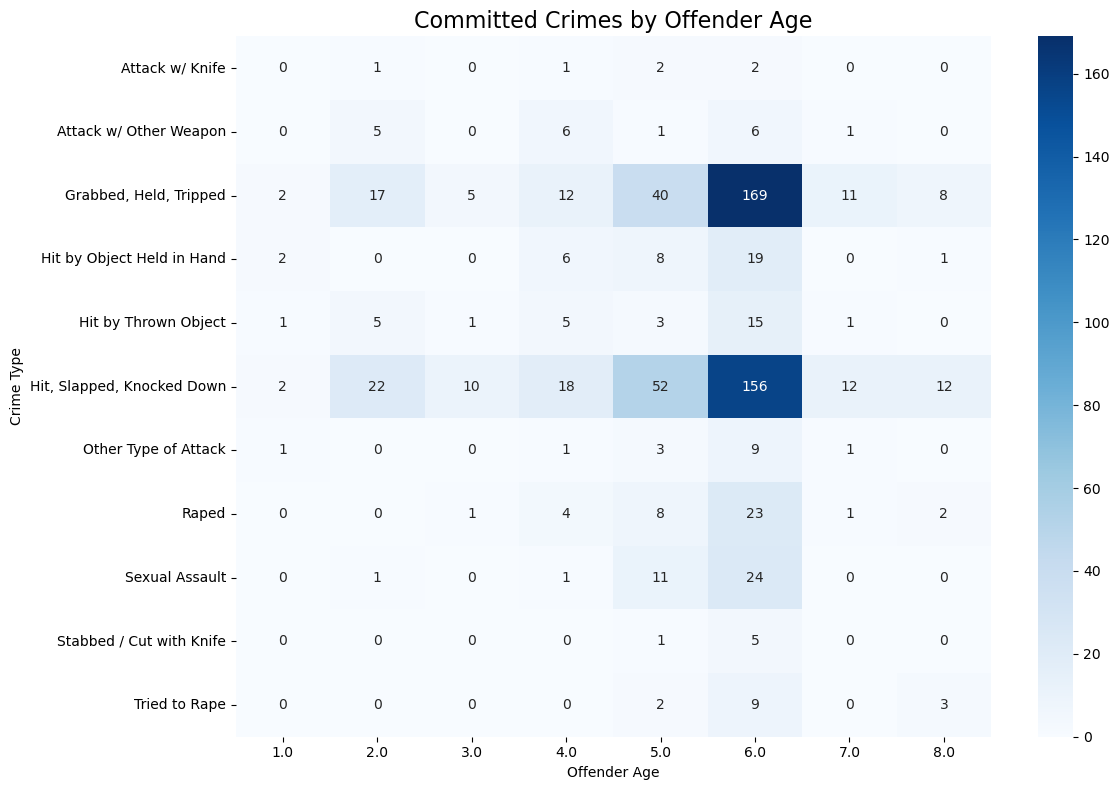

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

# Offender age column name (replace with actual)
offender_age_col = "V4237"

# Create attempted_df
attempted_records = []
for var, label in attempt_labels.items():
    if var in df.columns:
        counts_by_age = df[df[var] == 1][offender_age_col].value_counts()
        for age, count in counts_by_age.items():
            attempted_records.append({"Crime": label, "Offender Age": age, "Count": count})

attempted_df = pd.DataFrame(attempted_records)

# Create committed_df
committed_records = []
for var, label in committed_labels.items():
    if var in df.columns:
        counts_by_age = df[df[var] == 1][offender_age_col].value_counts()
        for age, count in counts_by_age.items():
            committed_records.append({"Crime": label, "Offender Age": age, "Count": count})

committed_df = pd.DataFrame(committed_records)

# --- Filter crimes with >5 total cases ---
attempted_filtered = attempted_df.groupby('Crime').filter(lambda x: x['Count'].sum() > 5)
committed_filtered = committed_df.groupby('Crime').filter(lambda x: x['Count'].sum() > 5)

# --- Attempted heatmap ---
attempted_pivot = attempted_filtered.pivot_table(
    index='Crime',
    columns='Offender Age',
    values='Count',
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(12, 8))
sns.heatmap(attempted_pivot, cmap="Reds", annot=True, fmt=".0f")
plt.title("Attempted Crimes by Offender Age", fontsize=16)
plt.ylabel("Crime Type")
plt.xlabel("Offender Age")
plt.tight_layout()
plt.show()

# --- Committed heatmap ---
committed_pivot = committed_filtered.pivot_table(
    index='Crime',
    columns='Offender Age',
    values='Count',
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(12, 8))
sns.heatmap(committed_pivot, cmap="Blues", annot=True, fmt=".0f")
plt.title("Committed Crimes by Offender Age", fontsize=16)
plt.ylabel("Crime Type")
plt.xlabel("Offender Age")
plt.tight_layout()
plt.show()


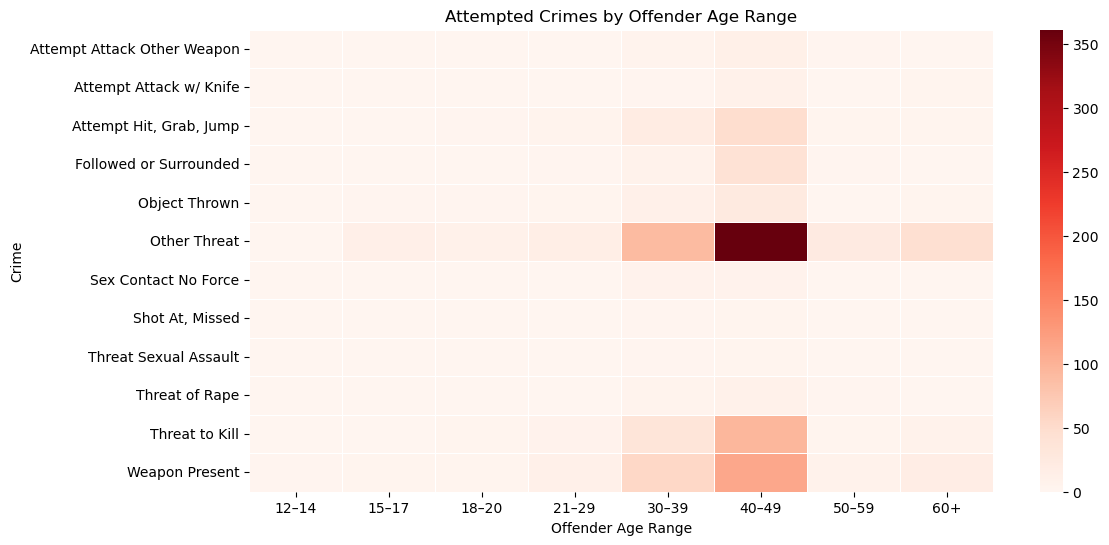

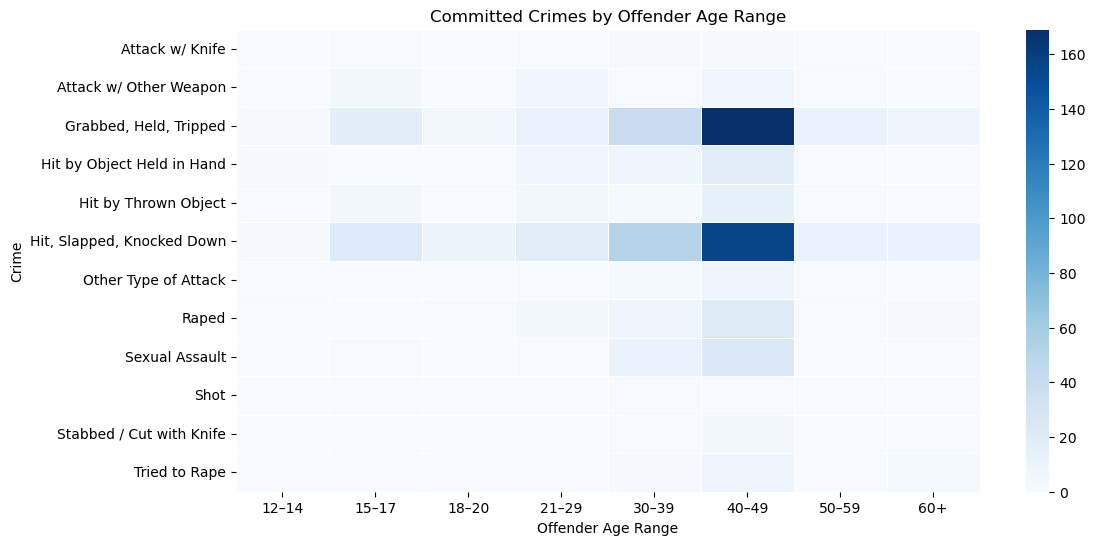

In [131]:
# --- Define mapping from codes to age ranges ---
age_mapping = {
    1: "12–14",
    2: "15–17",
    3: "18–20",
    4: "21–29",
    5: "30–39",
    6: "40–49",
    7: "50–59",
    8: "60+",
    9: "DK/Refused"
}

# --- Apply mapping to both DataFrames ---
attempted_df['Offender Age Range'] = attempted_df[offender_age_col].map(age_mapping)
committed_df['Offender Age Range'] = committed_df[offender_age_col].map(age_mapping)

# --- Filter again ---
attempted_filtered = attempted_df.groupby('Crime').filter(lambda x: len(x) > 5)
committed_filtered = committed_df.groupby('Crime').filter(lambda x: len(x) > 5)

# --- Attempted heatmap ---
plt.figure(figsize=(12, 6))
sns.heatmap(pd.crosstab(attempted_filtered['Crime'], attempted_filtered['Offender Age Range']),
            cmap="Reds", linewidths=.5)
plt.title("Attempted Crimes by Offender Age Range")
plt.show()

# --- Committed heatmap ---
plt.figure(figsize=(12, 6))
sns.heatmap(pd.crosstab(committed_filtered['Crime'], committed_filtered['Offender Age Range']),
            cmap="Blues", linewidths=.5)
plt.title("Committed Crimes by Offender Age Range")
plt.show()


In [198]:
q("""
SELECT V4236, COUNT(*) as count
FROM analytic_single_offender
GROUP BY V4236
ORDER BY V4236
""")


,V4236,count
0,NaN,6533
1,1.0,1567
2,2.0,420
3,3.0,56
4,8.0,53


In [199]:
q("""
SELECT V4236, COUNT(*) as count
FROM analytic_single_offender
WHERE V4236 IN (1, 2)
GROUP BY V4236
ORDER BY V4236
""")


,V4236,count
0,1.0,1567
1,2.0,420


In [204]:
from sqlalchemy import text

# Use the engine instead of q()
with engine.begin() as conn:
    conn.execute(text("DROP TABLE IF EXISTS analytic_single_offender_sex"))
    conn.execute(text("""
        CREATE TABLE analytic_single_offender_sex AS
        SELECT *,
               CASE 
                   WHEN V4236 = 1 THEN 'Male'
                   WHEN V4236 = 2 THEN 'Female'
               END AS Offender_Sex
        FROM analytic_single_offender
        WHERE V4236 IN (1, 2)
    """))



In [205]:
q("""
SELECT Offender_Sex, COUNT(*) AS count
FROM analytic_single_offender_sex
GROUP BY Offender_Sex
""")


,Offender_Sex,count
0,Female,420
1,Male,1567


In [209]:
# Drop and create the table in one transaction
with engine.begin() as conn:
    # Drop table if it exists
    conn.exec_driver_sql("DROP TABLE IF EXISTS analytic_single_offender_sex_demo")
    
    # Create new table with only Male/Female offenders
    conn.exec_driver_sql("""
    CREATE TABLE analytic_single_offender_sex_demo AS
    SELECT a.*,
           CASE 
               WHEN a.V4236 = 1 THEN 'Male'
               WHEN a.V4236 = 2 THEN 'Female'
           END AS Offender_Sex
    FROM analytic_single_offender a
    WHERE a.V4236 IN (1, 2)
    """)


In [210]:
q("SELECT * FROM analytic_single_offender_sex_demo LIMIT 5")


,_orig_idx,YEARQ,IDHH,IDPER,V4012,V4013,V4014,V4015,V4016,V4017,...,V4517,V4518,V4519,V4520,V4522,V4523,V4234_label,_seq,UniqueID,Offender_Sex
0,19,2021.1,1710111608023176563845223,171011160802317656384522301,1.0,NaN,9.0,2020.0,1.0,1.0,...,None,None,None,None,None,None,Only one,1,2021.1_1710111608023176563845223_1710111608023...,Female
1,26,2021.1,1710271999352528565649112,171027199935252856564911201,1.0,NaN,8.0,2020.0,1.0,1.0,...,None,None,None,None,None,None,Only one,2,2021.1_1710271999352528565649112_1710271999352...,Male
2,28,2021.1,1710404158350893565959322,171040415835089356595932201,1.0,2.0,9.0,2020.0,1.0,1.0,...,None,None,None,None,None,None,Only one,1,2021.1_1710404158350893565959322_1710404158350...,Male
3,40,2021.1,1710620299412156564932122,171062029941215656493212204,1.0,NaN,8.0,2020.0,1.0,1.0,...,None,None,None,None,None,None,Only one,1,2021.1_1710620299412156564932122_1710620299412...,Male
4,43,2021.1,1710623525467337564938132,171062352546733756493813201,1.0,NaN,12.0,2020.0,1.0,1.0,...,None,None,None,None,None,None,Only one,1,2021.1_1710623525467337564938132_1710623525467...,Female


In [212]:
# Check columns for analytic_single_offender
q("PRAGMA table_info(analytic_single_offender)")

# Check columns for offender_demographics
q("PRAGMA table_info(offender_demographics)")


,cid,name,type,notnull,dflt_value,pk
0,0,UniqueID,TEXT,0,None,0
1,1,V4248,TEXT,0,None,0
2,2,V4236,TEXT,0,None,0
3,3,V4237,TEXT,0,None,0
4,4,V4238,TEXT,0,None,0
5,5,V4239,TEXT,0,None,0
6,6,V4240,TEXT,0,None,0
7,7,V4241,TEXT,0,None,0
8,8,V4242,TEXT,0,None,0
9,9,V4243,TEXT,0,None,0


In [220]:
with engine.begin() as conn:
    conn.exec_driver_sql("DROP TABLE IF EXISTS analytic_single_offender_sex_demo")
    
    conn.exec_driver_sql("""
    CREATE TABLE analytic_single_offender_sex_demo AS
    SELECT a.*,
           CASE 
               WHEN a.V4236 = 1 THEN 'Male'
               WHEN a.V4236 = 2 THEN 'Female'
           END AS Offender_Sex,
           d.*
    FROM analytic_single_offender a
    LEFT JOIN offender_demographics d
           ON a.UniqueID = d.UniqueID
    WHERE a.V4236 IN (1, 2)
    """)



In [225]:
import pandas as pd

# --- Inspect columns (already saw these in your screenshot) ---
left_cols  = set(df.columns)
right_cols = set(offender_sex_df.columns)

# --- Decide join strategy ---
use_composite = {'IDHH','IDPER'}.issubset(left_cols) and {'IDHH','IDPER'}.issubset(right_cols)

if use_composite:
    key = ['IDHH','IDPER']
    right = offender_sex_df.copy()
    print("Merging on composite key:", key)
else:
    # Fallback: assume UniqueID == IncidentID in your pipeline
    right = offender_sex_df.copy()
    if 'UniqueID' in right.columns and 'IncidentID' in df.columns:
        right = right.rename(columns={'UniqueID': 'IncidentID'})
        key = ['IncidentID']
        print("Merging on single key:", key, "(renamed UniqueID -> IncidentID)")
    else:
        raise KeyError("No compatible join keys found. "
                       "Expected either both frames to have IDHH+IDPER, "
                       "or offender_sex_df to have UniqueID while df has IncidentID.")

# --- Keep only needed columns from right, drop dupes on key ---
sex_col = next((c for c in right.columns if c.lower() in ['offender_sex','offender sex','off_sex','offender_gender']), None)
if sex_col is None:
    raise KeyError("Couldn’t find an offender sex column in offender_sex_df.")

right_slim = right[key + [sex_col]].drop_duplicates(subset=key)

# --- Merge (expect m:1) ---
df = df.merge(right_slim, on=key, how='left', validate='m:1')

# --- Standardize column name and show diagnostics ---
if sex_col != 'Offender_Sex':
    df = df.rename(columns={sex_col: 'Offender_Sex'})

print(df['Offender_Sex'].value_counts(dropna=False))
print("Rows with missing Offender_Sex after merge:", df['Offender_Sex'].isna().sum())


Merging on composite key: ['IDHH', 'IDPER']
Offender_Sex
NaN       6494
Male      1974
Female     514
Name: count, dtype: int64
Rows with missing Offender_Sex after merge: 6494


In [227]:
# 1) Pull the table that already has Offender_Sex
sex_df = q("""
SELECT *
FROM analytic_single_offender_sex
""").copy()

# 2) Keep canonical key + sex; drop any dup keys
keep_cols = [c for c in ['YEARQ','IDHH','IDPER','Offender_Sex'] if c in sex_df.columns]
sex_base = sex_df[keep_cols].dropna(subset=['Offender_Sex']).drop_duplicates(subset=['YEARQ','IDHH','IDPER'])

# 3) Overall distribution
overall = (sex_base['Offender_Sex']
           .value_counts(dropna=False)
           .to_frame('count'))
overall['percent'] = (overall['count'] / overall['count'].sum() * 100).round(2)
overall


,count,percent
Offender_Sex,,
Male,1325,79.34
Female,345,20.66


In [228]:
import pandas as pd

def sex_xtab(df, col, normalize='index'):
    # normalize='index' -> row percents; use None for raw counts only
    tab = pd.crosstab(df['Offender_Sex'], df[col], dropna=False)
    if normalize in ('index','columns','all'):
        pct = pd.crosstab(df['Offender_Sex'], df[col], normalize=normalize, dropna=False).round(3)
        return tab, pct
    return tab

# Example: replace 'V4012' with any column in analytic_single_offender_sex
counts, pct = sex_xtab(sex_df, 'V4012', normalize='index')
counts, pct


(V4012          1.0  2.0  3.0  4.0  5.0  6.0
 Offender_Sex                               
 Female         364   33   15    7    1    0
 Male          1372  127   42   17    6    3,
 V4012           1.0    2.0    3.0    4.0    5.0    6.0
 Offender_Sex                                          
 Female        0.867  0.079  0.036  0.017  0.002  0.000
 Male          0.876  0.081  0.027  0.011  0.004  0.002)

In [230]:
print("Attempted DF:", attempted_df.shape)
display(attempted_df.head())

print("Committed DF:", committed_df.shape)
display(committed_df.head())


Attempted DF: (1436, 3)


,V4237,Crime,Offender Age Range
0,8.0,Threat of Rape,60+
1,5.0,Threat of Rape,30–39
2,5.0,Threat of Rape,30–39
3,5.0,Threat of Rape,30–39
4,6.0,Threat of Rape,40–49


Committed DF: (14, 1)


,Committed Count
Raped,45.0
Tried to Rape,14.0
Sexual Assault,40.0
Shot,7.0
"Shot At, Missed",0.0


In [231]:
import pandas as pd
import re

# Replace this with the same source you used for attempted_df.
# If you already have it as a DataFrame, set `src = that_dataframe`.
# If it lives in SQL, uncomment and pull it:
# src = q("""SELECT V4237, Crime, "Offender Age Range" FROM <your_incident_view_or_table>""")

# For safety, infer the source from attempted_df if you don't have 'src' handy:
# (This only works if attempted_df already has all three columns and you can reload the same view later.)
cols_needed = ['V4237', 'Crime', 'Offender Age Range']
assert all(c in attempted_df.columns for c in cols_needed), "Need V4237, Crime, Offender Age Range in attempted_df or in your source."

# If you have the real incident-level `src`, use it; otherwise reconstruct from attempted_df for now:
try:
    src  # noqa: F821
except NameError:
    src = attempted_df.copy()

# --- Normalize text and split attempted vs committed ----------------------------
crime_clean = src['Crime'].astype(str).str.strip()

attempt_terms = re.compile(r'(?i)\b(threat|attempt|tried)\b')  # case-insensitive
is_attempted = crime_clean.str.contains(attempt_terms, na=False)

attempted_long  = src.loc[is_attempted, cols_needed].copy()
committed_long  = src.loc[~is_attempted, cols_needed].copy()

# Optional: drop obvious non-crime placeholders, if any slipped in
bad_labels = {'nan', '', 'none', 'missing'}
committed_long = committed_long[~committed_long['Crime'].str.lower().isin(bad_labels)]

# --- Final outputs --------------------------------------------------------------
attempted_df = attempted_long.reset_index(drop=True)
committed_df = committed_long.reset_index(drop=True)

print("Attempted:", attempted_df.shape)
print("Committed:", committed_df.shape)
display(attempted_df.head())
display(committed_df.head())


Attempted: (1002, 3)
Committed: (434, 3)


/var/folders/jw/2sxw6r3s4vv1qxy3y8bt9tg00000gn/T/ipykernel_1183/1256441831.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  is_attempted = crime_clean.str.contains(attempt_terms, na=False)


,V4237,Crime,Offender Age Range
0,8.0,Threat of Rape,60+
1,5.0,Threat of Rape,30–39
2,5.0,Threat of Rape,30–39
3,5.0,Threat of Rape,30–39
4,6.0,Threat of Rape,40–49


,V4237,Crime,Offender Age Range
0,6.0,Sex Contact w/ Force,40–49
1,6.0,Sex Contact w/ Force,40–49
2,6.0,Sex Contact w/ Force,40–49
3,7.0,Sex Contact No Force,50–59
4,6.0,Sex Contact No Force,40–49
